In [1]:
%load_ext watermark
%watermark

2019-05-25T11:47:30+02:00

CPython 3.6.5
IPython 6.4.0

compiler   : GCC 7.2.0
system     : Linux
release    : 5.1.2-arch1-1-ARCH
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit


# Separacion de datos entrenamiento, test y validacion cruzada

Separamos nuestro dataset en 2 partes el dataset de entrenamiento y el dataset de test, basicamente quitamos un trozo del dataset original, entrenamos a la máquina con el resto del dataset, hacemos el modelo predictivo y evaluamos el modelo con el trozo que quitamos. Evitamos así el sobreajuste, no queremos que memorice el modelo, sino que generalice

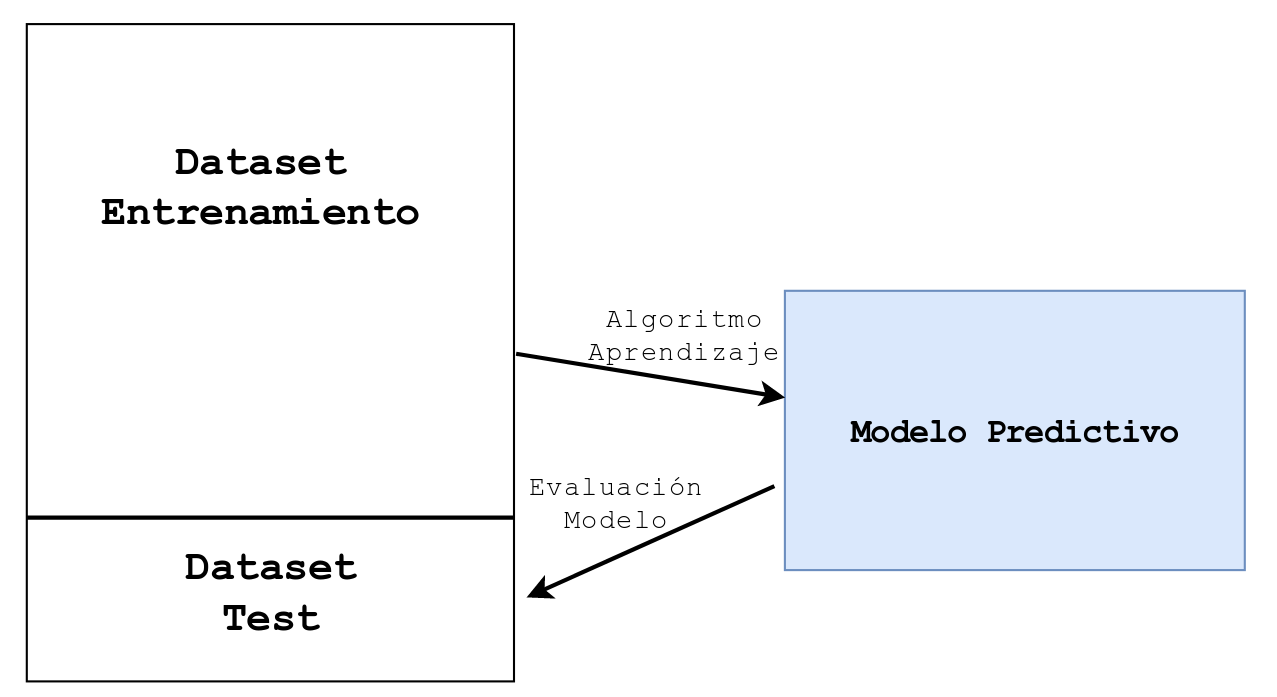

In [2]:
from IPython.display import Image
Image("../../RESOURCES/train_test_split.jpg")

In [3]:
import numpy as np 

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import datasets

In [4]:
boston = datasets.load_boston()

In [5]:
# Error cuadrático medio
def root_mean_square_error(objetivo, estimaciones):
    return np.sqrt(metrics.mean_squared_error(objetivo, estimaciones))
# Ajuste al r2
def adjusted_r2(objetivo, estimaciones, n, k):
    r2 = metrics.r2_score(objetivo, estimaciones)
    return 1 - (1-r2)*(n-1) / (n - k - 1)
#Evaliacion del modelo
def evaluar_modelo(objetivo, estimaciones, n, k):
    return {
        "rmse": root_mean_square_error(objetivo, estimaciones),
        "mae": metrics.mean_absolute_error(objetivo, estimaciones),
        "adjusted_r2": adjusted_r2(objetivo, estimaciones, n, k) 
    }

In [6]:
modelo_ols = LinearRegression()

modelo_ols.fit(X=boston["data"], y=boston["target"])

modelo_ols_preds = modelo_ols.predict(boston["data"])

In [7]:
RESULTADOS = {}

In [8]:
#tamanio de la muestra
N = boston["data"].shape[0]

RESULTADOS["ols"] = evaluar_modelo(boston["target"],
                                  modelo_ols_preds,
                                  N,
                                  len(modelo_ols.coef_))
RESULTADOS

{'ols': {'rmse': 4.679191295697281,
  'mae': 3.2708628109003137,
  'adjusted_r2': 0.733789726372463}}

Esto no tiene sentido porque estamos haciendo un sobreajuste por defecto y en el entramiento le damos todo los datos y es probable que no genere analisis bien con datos nuevos que no tenemos ahora mismo (autosampler)

Vamos a separar los datos de entrenamiento de los de test

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_test_split?

In [11]:
boston["data"].shape

(506, 13)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    boston["data"],
    boston["target"],
    test_size=0.33,
    random_state=13
)

sacamos un tercio para el test

In [13]:
print(X_train.shape, y_train.shape)

(339, 13) (339,)


In [14]:
print(X_test.shape, y_test.shape)

(167, 13) (167,)


Entrenamos al modelo con los datos de entrenamiento

In [15]:
modelo_ols = LinearRegression()
modelo_ols.fit(X=X_train, y=y_train)
modelo_ols_train_preds = modelo_ols.predict(X_train)

In [16]:
RESULTADOS["ols_train"] = evaluar_modelo(
    y_train,
    modelo_ols_train_preds,
    X_train.shape[0],
    len(modelo_ols.coef_)
)

Ahora vamos a predecir usando el modelo entrenado con los datos de test

Y evaluamos el modelo con los datos de test

In [17]:
modelo_ols_test_preds = modelo_ols.predict(X_test)

RESULTADOS["ols_test"] = evaluar_modelo(
    y_test,
    modelo_ols_test_preds,
    X_test.shape[0],
    len(modelo_ols.coef_)
)

In [18]:
import pandas as pd

In [19]:
pd.DataFrame(RESULTADOS)

,ols,ols_train,ols_test
adjusted_r2,0.733790,0.731491,0.688716
mae,3.270863,3.300868,3.558434
rmse,4.679191,4.721732,4.784178


Vemos que al seperar los datos de entrenamiento y los que test se obtiene un resultado peor al evaluar los datos de test.

Podríamos parar aquí y decir "El error RMSW de mi modelo es 4.787026", podríamos pensar que esta todo bien ya que no hemos entrenados el modelo en los que hemos usado para evaluarlo.

Pero estaríamos en un grave error. ¿Por qué?


Recordad que hemos un `random_state=13` para la función `train_test_split`que garantiza que la separación de entranamiento y test sea siempre la misma. Podemos usar cualquier número para este argumento.

Qué pasa si usamos por ejemplo `random_state=42`?

In [20]:
RESULTADOS = {}

X_train, X_test, y_train, y_test = train_test_split(
    boston["data"],
    boston["target"],
    test_size=0.33,
    random_state=42
)

modelo_ols = LinearRegression()
modelo_ols.fit(X=X_train, y=y_train)
modelo_ols_train_preds = modelo_ols.predict(X_train)

RESULTADOS["ols_train"] = evaluar_modelo(
    y_train,
    modelo_ols_train_preds,
    X_train.shape[0],
    len(modelo_ols.coef_)
)

modelo_ols_test_preds = modelo_ols.predict(X_test)

RESULTADOS["ols_test"] = evaluar_modelo(
    y_test,
    modelo_ols_test_preds,
    X_test.shape[0],
    len(modelo_ols.coef_)
)

pd.DataFrame(RESULTADOS)

,ols_train,ols_test
adjusted_r2,0.728804,0.702889
mae,3.376419,3.148256
rmse,4.794269,4.552365


El error en los datos de test es menor que en los entrenamiento ¿Por qué? Sencillamente, por que ha dado la casualidad de que hemos separado los datos de una forma que los datos de test son muy fáciles de estimar.

In [21]:
model = LinearRegression()
results = []
def test_seed(seed):
    X_train, X_test, y_train, y_test = train_test_split(
    boston["data"], boston["target"],
        test_size=0.33, random_state=seed
    )
    test_preds = model.fit(X_train, y_train).predict(X_test)
    seed_rmse = root_mean_square_error(y_test, test_preds)
    results.append([seed_rmse, seed])

In [22]:
for i in range(1000):
    test_seed(i)

In [23]:
results_sorted = sorted(results, key=lambda x: x[0], reverse=False)

In [24]:
results_sorted[0]

[3.631314217076931, 635]

In [25]:
results_sorted[-1]

[6.788054714003132, 645]

conclusion.... Estos significa que no podemos hacer solo una particion de los datos, eso es jugartela demasiado.

### Validación Cruzada

Vemos que entre la semilla con menor error de test y la semilla con mayor error hay una diferencia del doble

Una forma de evitar el cometer este error es mediante la **Validación cruzada**


![cross_val](https://cdn-images-1.medium.com/max/1600/1*J2B_bcbd1-s1kpWOu_FZrg.png)

In [26]:
from sklearn.model_selection import cross_val_score

In [27]:
cross_val_score?

In [28]:
modelo_ols = LinearRegression()
X = boston["data"]
y = boston["target"]

resultados_validacion_cruzada = cross_val_score(
    estimator=modelo_ols,
    X=X,
    y=y,
    scoring = "neg_mean_squared_error",
    cv=10
)

In [29]:
resultados_validacion_cruzada

array([  -9.28694671,  -14.15128316,  -14.07360615,  -35.20692433,
        -31.88511666,  -19.83587796,   -9.94726918, -168.37537954,
        -33.32974507,  -10.96041068])

In [30]:
def rmse_cross_validation(estimator, X, y):
    y_pred = estimator.predict(X)
    return np.sqrt(metrics.mean_absolute_error(y, y_pred))

In [31]:
resultados_cv = []
for i in range(10,200):
    cv_rmse = cross_val_score(
    estimator=modelo_ols,
        X=X,
        y=y,
        scoring=rmse_cross_validation,
        cv=i
    ).mean()
    resultados_cv.append(cv_rmse)

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

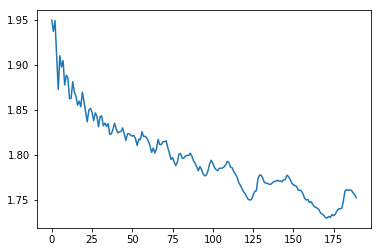

In [33]:
plt.plot(resultados_cv)

In [34]:
from sklearn.model_selection import cross_validate
scoring = {"mae": "neg_mean_absolute_error", "rmse": rmse_cross_validation}
estimator = modelo_ols
scores = cross_validate(estimator,
                       boston["data"],
                       boston["target"],
                       scoring=scoring,
                       cv=10,
                       return_train_score=True)

In [35]:
cross_validate?

In [36]:
pd.DataFrame(scores).mean()

fit_time      0.001731
score_time    0.001080
test_mae     -4.004947
train_mae    -3.247644
test_rmse     1.949203
train_rmse    1.800855
dtype: float64